## **Algoritmo de BackPropagation multiclase**

  Este codigo se utilizará para entrenar la red neuronal de clasificacion de Nuestras Caras



## **Preparar el entorno en Google Colab**

En esta sección se configura el entorno de trabajo para desarrollar el proyecto en Google Colab. Se monta Google Drive para acceder a archivos almacenados, se definen rutas base y se crean carpetas necesarias para guardar resultados, modelos o salidas del entrenamiento.

In [2]:
# conexion al Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Cargar las librerias que vamos a utilizar**

En esta sección se importan las librerías requeridas para el desarrollo del proyecto

In [3]:
# instalo  itables solo si no esta instalado
!pip show itables >/dev/null || pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.0 MB/s eta 0:00:00


In [4]:
import polars as pl
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import time
import os
import pickle
from functools import reduce
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
from sklearn.preprocessing import LabelEncoder

## **Definición de clase para visualización del perceptrón**

Esta sección del proyecto define una clase que permite visualizar gráficamente cómo el perceptrón va aprendiendo a lo largo del entrenamiento. Para ello, muestra los datos proyectados en dos dimensiones junto con las rectas de decisión generadas por las neuronas de la primera capa oculta. A medida que avanzan las épocas, el gráfico se actualiza dinámicamente, permitiendo observar cómo el modelo ajusta sus pesos para separar las distintas clases.

In [5]:
# definicion de la clase de graficos

class perceptron_plot:
    """plotting first hidden layer class"""
    def __init__(self, X, Y, delay) -> None:
        self.X = X
        self.Y = Y
        self.delay = delay
        x1_min = np.min(X[:,0])
        x2_min = np.min(X[:,1])
        x1_max = np.max(X[:,0])
        x2_max = np.max(X[:,1])
        self.x1_min = x1_min - 0.1*(x1_max - x1_min)
        self.x1_max = x1_max + 0.1*(x1_max - x1_min)
        self.x2_min = x2_min - 0.1*(x2_max - x2_min)
        self.x2_max = x2_max + 0.1*(x2_max - x2_min)
        self.fig = plt.figure(figsize = (10,8))
        self.ax = self.fig.subplots()
        self.ax.set_xlim(self.x1_min, self.x1_max, auto=False)
        self.ax.set_ylim(self.x2_min, self.x2_max, auto=False)

    def graficarVarias(self, W, x0, epoch, error) -> None:
        display.clear_output(wait =True)
        plt.cla()
        #self.ax = self.fig.subplots()

        self.ax.set_xlim(self.x1_min, self.x1_max)
        self.ax.set_ylim(self.x2_min, self.x2_max)
        plt.title( 'epoch ' + str(epoch) + '  reg ' + "{0:.2E}".format(error))
        # ploteo puntos
        num_classes = len(np.unique(self.Y))
        # mycolors = plt.cm.get_cmap('tab10', num_classes)
        #scatter = self.ax.scatter(self.X[:,0], self.X[:,1], c=self.Y, s=20)
        Y_numerico = LabelEncoder().fit_transform(self.Y)
        scatter = self.ax.scatter(self.X[:,0], self.X[:,1], c=Y_numerico, s=20, cmap="tab10")
        # self.ax.plot(self.X[:,0], self.X[:,1], 'o', c=vcolores,  markersize=2)


        # dibujo las rectas
        for i in range(len(x0)):
            #vx2_min = -(W[0,i]*self.x1_min + x0[i])/W[1,i]
            #vx2_max = -(W[0,i]*self.x1_max + x0[i])/W[1,i]
            vx2_min = -(W[i,0]*self.x1_min + x0[i])/W[i,1]
            vx2_max = -(W[i,0]*self.x1_max + x0[i])/W[i,1]

            self.ax.plot([self.x1_min, self.x1_max],
                         [vx2_min, vx2_max],
                         linewidth = 2,
                         color = 'red',
                         alpha = 0.5)

        display.display(plt.gcf())
        #plt.cla()
        time.sleep(self.delay)


## **Función de activación softmax**

Se define la función softmax, utilizada en la capa de salida de redes neuronales para convertir los resultados en una distribución de probabilidades. La implementación incluye una corrección para garantizar la estabilidad numérica y evitar errores de precisión durante el cálculo.

In [6]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=0, keepdims=True))  # estabilidad numérica
    return e_x / np.sum(e_x, axis=0, keepdims=True)

## **Definición de funciones de activación y sus derivadas**

En esta parte se definen las funciones de activación que puede usar la red neuronal, como purelin, logsig, tansig y softmax, junto con sus derivadas. Estas funciones permiten que el modelo aprenda relaciones no lineales entre los datos. También se agregan versiones vectorizadas para que puedan aplicarse de manera eficiente sobre múltiples datos al mismo tiempo.

In [7]:
# definicion de las funciones de activacion
#  y sus derivadas
#  ahora agregando las versiones VECTORIZADAS

def func_eval(fname, x):
    if fname == "purelin":
        return x
    elif fname == "logsig":
        return 1.0 / (1.0 + np.exp(-x))
    elif fname == "tansig":
        return 2.0 / (1.0 + np.exp(-2.0 * x)) - 1.0
    elif fname == "softmax":
        return softmax(x)
    else:
        raise ValueError(f"Función de activación no soportada: {fname}")

# version vectorizada de func_eval
func_eval_vec = np.vectorize(func_eval)


def deriv_eval(fname, y):
    if fname == "purelin":
        return 1.0
    elif fname == "logsig":
        return y * (1.0 - y)
    elif fname == "tansig":
        return 1.0 - y * y
    elif fname == "softmax":
        return np.ones_like(y)  # placeholder

# version vectorizada de deriv_eval
deriv_eval_vec = np.vectorize(deriv_eval)

## **Implementación del modelo Multiperceptrón y entrenamiento con Backpropagation**


En esta sección se define la clase multiperceptron, que implementa desde cero una red neuronal multicapa. Incluye funcionalidades para inicializar la arquitectura, estandarizar los datos, aplicar codificación one-hot a las clases, entrenar el modelo utilizando el algoritmo de backpropagation y realizar predicciones. Durante el entrenamiento, se actualizan los pesos de cada capa en función del error y se grafican las rectas de separación de la primera capa oculta para visualizar el aprendizaje. También permite guardar y cargar el modelo entrenado, así como evaluar su desempeño en nuevos datos. Esta implementación brinda un control completo sobre el proceso de aprendizaje y visualización del comportamiento del modelo.

In [8]:
# definicion de la clase de multiperceptron

class multiperceptron(object):
    """Multiperceptron class"""

    # inicializacion de los pesos de todas las capas
    def _red_init(self, semilla) -> None:
        niveles = self.red['arq']['layers_qty']

        np.random.seed(semilla)
        for i in range(niveles):
           nivel = dict()
           nivel['id'] = i
           nivel['last'] = (i==(niveles-1))
           nivel['size'] = self.red["arq"]["layers_size"][i]
           nivel['func'] = self.red["arq"]["layers_func"][i]

           if( i==0 ):
              entrada_size = self.red['arq']['input_size']
           else:
              entrada_size =  self.red['arq']['layers_size'][i-1]

           salida_size =  nivel['size']

           # los pesos, inicializados random
           nivel['W'] = np.random.uniform(-0.5, 0.5, [salida_size, entrada_size])
           nivel['w0'] = np.random.uniform(-0.5, 0.5, [salida_size, 1])

           # los momentos, inicializados en CERO
           nivel['W_m'] = np.zeros([salida_size, entrada_size])
           nivel['w0_m'] = np.zeros([salida_size, 1])

           self.red['layer'].append(nivel)

    # constructor generico
    def __init__(self) -> None:
        self.data = dict()
        self.red = dict()
        self.carpeta = ""


    # inicializacion full
    def inicializar(self, df, campos, clase, hidden_layers_sizes, layers_func,
                 semilla, carpeta) -> None:

        # genero self.data
        self.data['X'] = np.array( df.select(campos))
        X_mean = self.data['X'].mean(axis=0)
        X_sd = self.data['X'].std(axis=0)
        self.data['X'] = (self.data['X'] - X_mean)/X_sd

        #  Ylabel en  numpy
        label =df.select(clase)
        self.data['Ylabel'] = np.array(label).reshape(len(label))

        # one-hot-encoding de Y
        col_originales = df.columns
        self.data['Y'] = np.array( df.to_dummies(clase).drop(col_originales, strict=False) )

        col_dummies = sorted( list( set(df.to_dummies(clase).columns) -  set(col_originales)))
        clases_originales = reduce(lambda acc, x: acc + [x[(len(clase)+1):]], col_dummies, [])

        tamanos = hidden_layers_sizes
        tamanos.append(self.data['Y'].shape[1])

        arquitectura = {
             'input_size' : self.data['X'].shape[1],
             'input_mean' : X_mean,
             'input_sd' :  X_sd,
             'output_values' : clases_originales,
             'layers_qty' : len(hidden_layers_sizes), # incluye la capa de salida, pero no la de entrada
             'layers_size' : tamanos ,
             'layers_func' : layers_func,
        }

        self.red['arq'] = arquitectura


        # inicializo  work
        self.red['work'] = dict()
        self.red['work']['epoch'] = 0
        self.red['work']['MSE'] = float('inf')
        self.red['work']['train_error_rate'] = float('inf')

        self.red['layer'] = list()
        self._red_init(semilla)

        # grabo el entorno
        self.carpeta = carpeta
        os.makedirs(self.carpeta, exist_ok=True)
        with open(self.carpeta+"/data.pkl", 'wb') as f:
            pickle.dump(self.data, f)

        with open(self.carpeta+"/red.pkl", 'wb') as f:
            pickle.dump(self.red, f)


    # Algoritmo Backpropagation
    def  entrenar(self, epoch_limit, MSE_umbral,
               learning_rate, lr_momento, save_frequency,
               retomar=True) -> None:

        # si debo retomar
        if( retomar):
            with open(self.carpeta+"/data.pkl", 'rb') as f:
              self.data = pickle.load(f)

            with open(self.carpeta+"/red.pkl", 'rb') as f:
              self.red = pickle.load(f)


        # inicializaciones del bucle principal del backpropagation
        epoch = self.red['work']['epoch']
        MSE = self.red['work']['MSE']

        # inicializacion del grafico
        grafico = perceptron_plot(X=self.data['X'], Y=self.data['Ylabel'], delay=0.1)

        # continuo mientras error cuadratico medio muy grande  y NO llegué al límite de epochs
        Xfilas = self.data['X'].shape[0]
        niveles = self.red["arq"]["layers_qty"]

        while ( MSE > MSE_umbral) and (epoch < epoch_limit) :
          epoch += 1


          # recorro siempre TODOS los registros de entrada
          for fila in range(Xfilas):
             # fila es el registro actual
             x = self.data['X'][fila:fila+1,:]
             clase = self.data['Y'][fila:fila+1,:]

             # propagar el x hacia adelante, FORWARD
             entrada = x.T  # la entrada a la red

             # etapa forward
             # recorro hacia adelante, nivel a nivel
             vsalida =  [0] *(niveles) # salida de cada nivel de la red

             for i in range(niveles):
               estimulos = self.red['layer'][i]['W'] @ entrada + self.red['layer'][i]['w0']
               if self.red['layer'][i]['func'] == "softmax":
                vsalida[i] = softmax(estimulos)
               else:
                vsalida[i] = func_eval_vec(self.red['layer'][i]['func'], estimulos)
               entrada = vsalida[i]  # para la proxima vuelta


             # etapa backward
             # calculo los errores en la capa hidden y la capa output
             verror =  [0] *(niveles+1) # inicializo dummy
             verror[niveles] = clase.T - vsalida[niveles-1]

             i = niveles-1
             verror[i] = verror[i+1] * deriv_eval_vec(self.red['layer'][i]['func'], vsalida[i])

             for i in reversed(range(niveles-1)):
               verror[i] = deriv_eval_vec(self.red['layer'][i]['func'], vsalida[i])*(self.red['layer'][i+1]['W'].T @ verror[i+1])

             # ya tengo los errores que comete cada capa
             # corregir matrices de pesos, voy hacia atras
             # backpropagation
             entrada = x.T
             for i in range(niveles):
               self.red['layer'][i]['W_m'] = learning_rate *(verror[i] @ entrada.T) + lr_momento *self.red['layer'][i]['W_m']
               self.red['layer'][i]['w0_m'] = learning_rate * verror[i] + lr_momento * self.red['layer'][i]['w0_m']

               self.red['layer'][i]['W']  =  self.red['layer'][i]['W'] + self.red['layer'][i]['W_m']
               self.red['layer'][i]['w0'] =  self.red['layer'][i]['w0'] + self.red['layer'][i]['w0_m']
               entrada = vsalida[i]  # para la proxima vuelta



          # ya recalcule las matrices de pesos
          # ahora avanzo la red, feed-forward
          # para calcular el red(X) = Y
          entrada = self.data['X'].T
          for i in range(niveles):
            estimulos = self.red['layer'][i]['W'] @ entrada + self.red['layer'][i]['w0']
            if self.red['layer'][i]['func'] == "softmax":
              salida = softmax(estimulos)
            else:
              salida = func_eval_vec(self.red['layer'][i]['func'], estimulos)
            entrada = salida  # para la proxima vuelta

          # calculo el error cuadratico medio TODOS los X del dataset
          MSE= np.mean( (self.data['Y'].T - salida)**2 )

          # Grafico las rectas SOLAMENTE de la Primera Hidden Layer
          # tengo que hacer w0.T[0]  para que pase el vector limpio
          if( epoch % save_frequency == 0 ) or ( MSE <= MSE_umbral) or (epoch >= epoch_limit) :
              # grafico
              W = self.red['layer'][0]['W']
              w0 = self.red['layer'][0]['w0']
              grafico.graficarVarias(W, w0.T[0], epoch, MSE)

              # almaceno en work
              self.red['work']['epoch'] = epoch
              self.red['work']['MSE'] = MSE
              prediccion = np.argmax( salida.T, axis=1)
              # prediccion
              out = np.array(self.red["arq"]['output_values'])
              error_rate = np.mean( self.data['Ylabel'] != out[prediccion])
              self.red["work"]['train_error_rate'] = error_rate # error_rate != error cuadratico medio

              # grabo a un archivo la red neuronal  entrenada por donde esté
              #   solo la red, NO los datos
              with open(carpeta+"/red.pkl", 'wb') as f:
                 pickle.dump(self.red, f)

        return (epoch, MSE, self.red['work']['train_error_rate'] )


    # predigo a partir de modelo recien entrenado
    def  predecir(self, df_new, campos, clase) -> None:
        niveles = self.red['arq']['layers_qty']

        # etapa forward
        # recorro hacia adelante, nivel a nivel
        X_new =  np.array( df_new.select(campos))


        # estandarizo manualmente
        #  con las medias y desvios que almacene durante el entrenamiento
        X_new = (X_new - self.red['arq']['input_mean'])/self.red['arq']['input_sd']

        # grafico los datos nuevos
        Ylabel_new =df_new.select(clase)
        Ylabel_new = np.array(Ylabel_new).reshape(len(Ylabel_new))
        grafico = perceptron_plot(X=X_new, Y=Ylabel_new, delay=0.1)
        W = self.red['layer'][0]['W']
        w0 = self.red['layer'][0]['w0']
        grafico.graficarVarias(W, w0.T[0], epoch, MSE)

        # la entrada a la red,  el X que es TODO  x_new
        entrada = X_new.T  # traspongo, necesito vectores columna

        for i in range(niveles):
          estimulos = self.red['layer'][i]['W'] @ entrada + self.red['layer'][i]['w0']
          if self.red['layer'][i]['func'] == "softmax":
            salida = softmax(estimulos)
          else:
            salida = func_eval_vec(self.red['layer'][i]['func'], estimulos)
          entrada = salida  # para la proxima vuelta

        # me quedo con la neurona de la ultima capa que se activio con mayor intensidad
        pred_idx = np.argmax(salida.T, axis=1)
        pred_raw_full = salida.T
        pred_raw_max = np.max(salida.T, axis=1)

        # calculo error_rate
        out = np.array(self.red['arq']['output_values'])
        error_rate = np.mean( np.array(df_new.select("y") != out[pred_idx]))

        return (out[pred_idx], pred_raw_full, error_rate)


    # cargo un modelo ya entrenado, grabado en carpeta
    def cargar_modelo(self, carpeta) -> None:
        self.carpeta = carpeta

        with open(self.carpeta+"/red.pkl", 'rb') as f:
          self.red = pickle.load(f)

        return (self.red['work']['epoch'],
                self.red['work']['MSE'],
                self.red['work']['train_error_rate'] )


## **Lectura del Dataset**

En esta sección se carga el dataset de entrenamiento previamente guardado utilizando pickle y se lo almacena como un DataFrame de Polars. Esta librería permite una lectura y manipulación de datos más rápida y eficiente, ideal para flujos de trabajo que requieren alto rendimiento. El dataset ya contiene las variables reducidas por ISOMAP y sus respectivas etiquetas, listas para ser utilizadas en el entrenamiento del modelo de red neuronal.

In [9]:
# Lectura del dataset con la moderna libreria Polars  (Pandas debe extinguirse!)

with open('/content/drive/MyDrive/DMA_Eigenfaces/modelos/isomap_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

### **Visualización inicial del dataset de entrenamiento**

 Esta sección se utiliza para verificar rápidamente que el DataFrame fue cargado correctamente, inspeccionar los nombres de las columnas, los valores y el formato general.

In [115]:
df_train.head()

shape: (5, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ x1        ┆ x2        ┆ x3        ┆ x4        ┆ … ┆ x8        ┆ x9        ┆ x10       ┆ y        │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 318.12151 ┆ -26.39095 ┆ -38.09245 ┆ -6.051849 ┆ … ┆ 28.217548 ┆ -12.68340 ┆ -14.97015 ┆ Federico │
│ 3         ┆ 8         ┆           ┆           ┆   ┆           ┆ 2         ┆ 6         ┆          │
│ -90.70426 ┆ -56.30033 ┆ -47.31643 ┆ -35.11656 ┆ … ┆ 28.213393 ┆ -0.316573 ┆ 39.027683 ┆ Jorgelin │
│ 3         ┆ 7         ┆ 1         ┆ 9         ┆   ┆           ┆           ┆           ┆ a        │
│ 10.980164 ┆ -119.8731 ┆ 8.536015  ┆ -22.53341 ┆ … ┆ -11.26242 ┆ -10.47414 ┆ -15.93966 ┆ NoeliaM  │
│           ┆ 64        ┆           ┆ 3         ┆   ┆ 4         ┆           ┆ 7         ┆          │
│ -121.6337 ┆ 60.992977 ┆ -96.78701 ┆ 77.544503 ┆ … ┆ 64.655433 ┆ 67.814836 ┆ -6.044339 ┆ Alejandr │
│ 33        ┆           ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆ o        │
│ -0.628002 ┆ 134.91836 ┆ -48.14756 ┆ -2.693082 ┆ … ┆ 56.070839 ┆ 27.066346 ┆ 17.405761 ┆ Alejandr │
│           ┆ 7         ┆ 9         ┆           ┆   ┆           ┆           ┆           ┆ o        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

## **Entrenamiento del modelo**

En esta etapa se entrena la red neuronal utilizando el algoritmo de backpropagation. El modelo ajusta sus pesos capa por capa para minimizar el error entre las predicciones y las salidas reales, aprendiendo así a clasificar correctamente las muestras del conjunto de entrenamiento

### **Inicializacion de la neural network**



Esta sección prepara por completo la red neuronal para su entrenamiento. Se define la estructura del modelo, incluyendo la cantidad de capas ocultas, el número de neuronas en cada una y las funciones de activación. Además, se estandarizan los datos de entrada, se codifican las etiquetas en formato one-hot y se inicializan aleatoriamente los pesos con una semilla fija para asegurar reproducibilidad. Finalmente, toda esta configuración (datos y arquitectura) se guarda en una carpeta llamada **red** para su posterior uso durante el entrenamiento.

In [10]:
# defino la red multiperceptron
carpeta = "/content/drive/MyDrive/DMA_Eigenfaces/modelos/red_nr1"  # cambiar con cada corrida
semilla_red = 198000  # define las rectas iniciales

# una sola capa oculta de 2 neuronas  [2]
# la capa oculta y la final tienen ambas logsig de activacion
mp = multiperceptron()

mp.inicializar(
    df=df_train, campos=[f"x{i+1}" for i in range(10)], clase="y",
    hidden_layers_sizes=[20, 8],
    layers_func=['logsig', 'logsig', 'softmax'],
    semilla=semilla_red,
    carpeta= carpeta
)

### **Visualización**

Se muestran las primeras filas del DataFrame df_train para comprobar que los datos proyectados por ISOMAP y las etiquetas correspondientes fueron cargados correctamente y están listos para ser utilizados en el modelo.

In [117]:
print(df_train.head())

shape: (5, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ x1        ┆ x2        ┆ x3        ┆ x4        ┆ … ┆ x8        ┆ x9        ┆ x10       ┆ y        │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 318.12151 ┆ -26.39095 ┆ -38.09245 ┆ -6.051849 ┆ … ┆ 28.217548 ┆ -12.68340 ┆ -14.97015 ┆ Federico │
│ 3         ┆ 8         ┆           ┆           ┆   ┆           ┆ 2         ┆ 6         ┆          │
│ -90.70426 ┆ -56.30033 ┆ -47.31643 ┆ -35.11656 ┆ … ┆ 28.213393 ┆ -0.316573 ┆ 39.027683 ┆ Jorgelin │
│ 3         ┆ 7         ┆ 1         ┆ 9         ┆   ┆           ┆           ┆           ┆ a        │
│ 10.980164 ┆ -119.8731 ┆ 8.536015  ┆ -22.53341 ┆ … ┆ -11.26242 ┆ -10.47414 

### **Entrenamiento de la red neuronal con Backpropagation**



En esta etapa se entrena la red neuronal utilizando el algoritmo de backpropagation, que ajusta los pesos de cada capa para minimizar el error. Para lograr un buen desempeño, fue necesario experimentar con distintos valores de hiperparámetros como el learning_rate, el lr_momento, el límite de épocas (epoch_limit) y el umbral de error cuadrático medio (MSE_umbral). Durante el train, se actualizan los pesos en cada iteración y se guarda el progreso periódicamente.

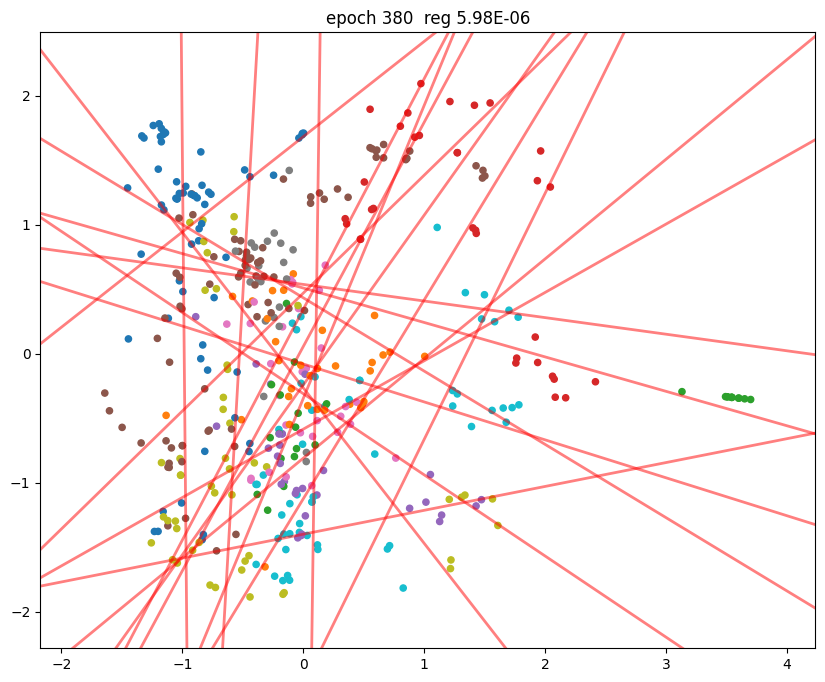

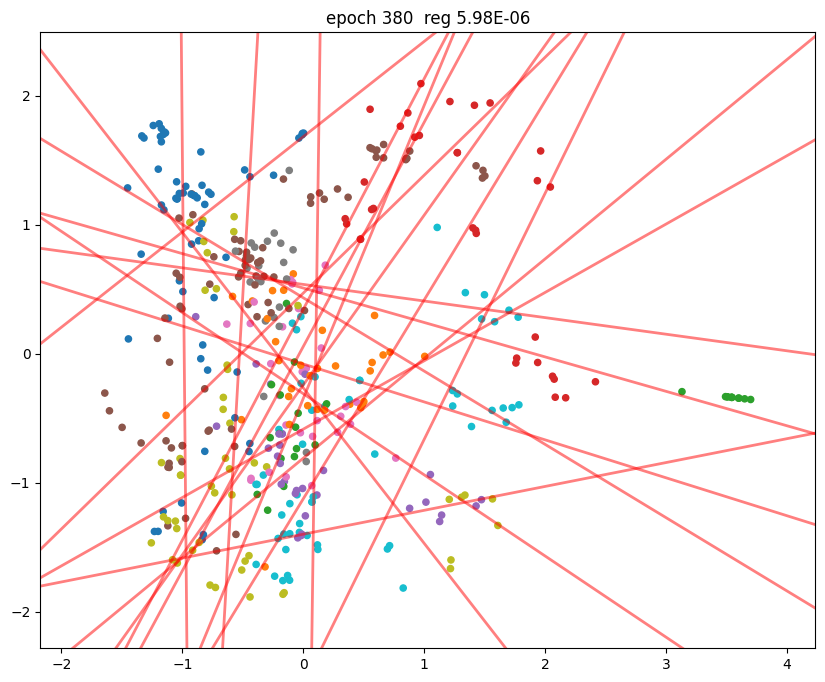

In [11]:
# entreno la neural netowork con BackPropagation

# el entrenamiento
(epoch, MSE, train_error_rate) = mp.entrenar(
    epoch_limit=1000,
    MSE_umbral=0.000006,
    learning_rate=0.1,
    lr_momento=0.2,
    save_frequency=100,
    retomar=True)


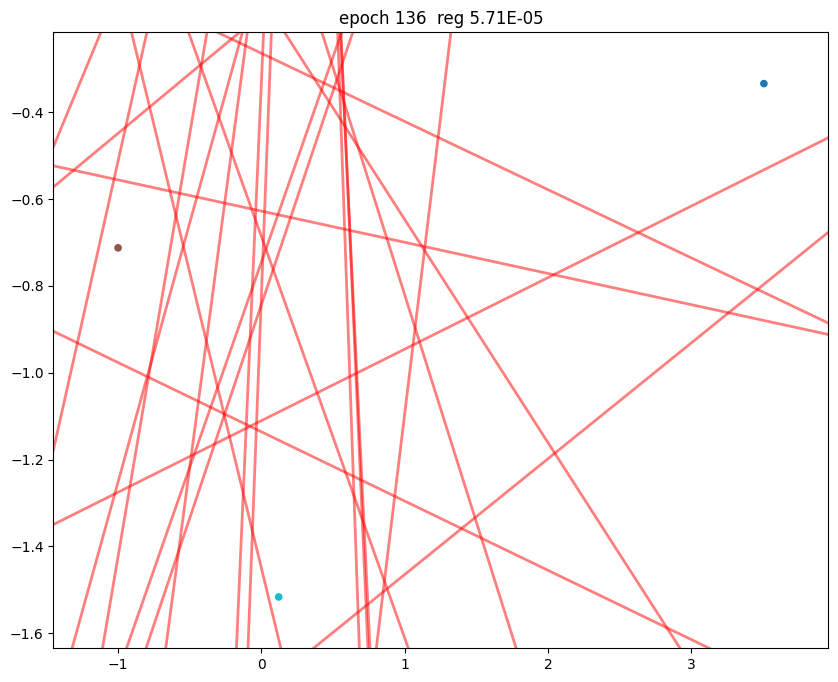

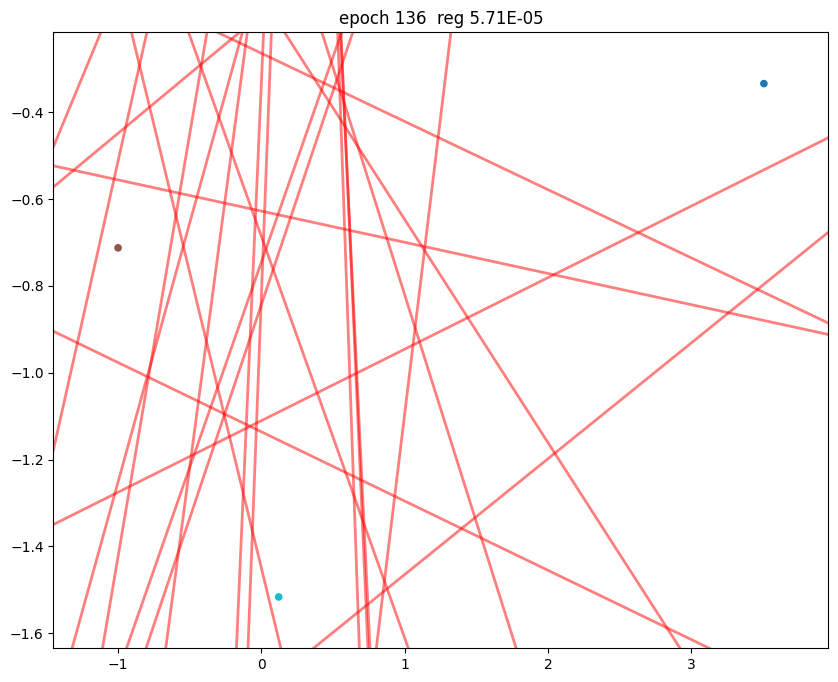

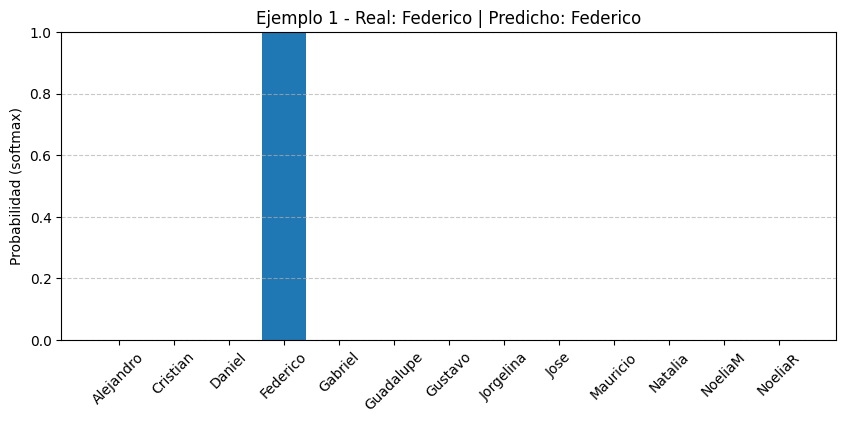

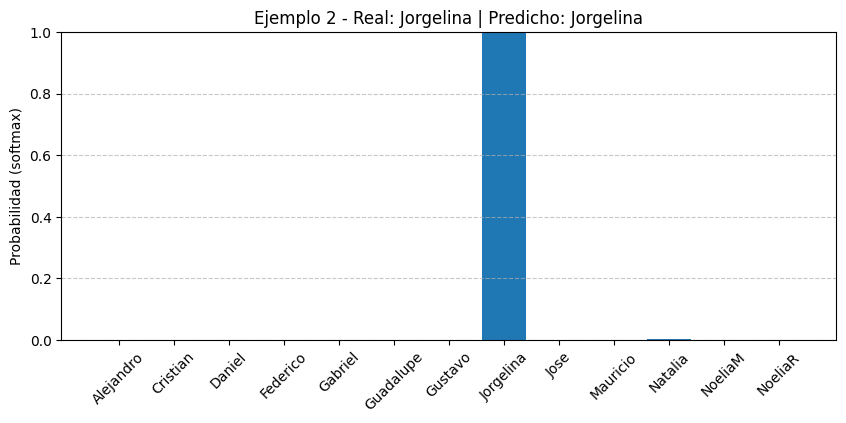

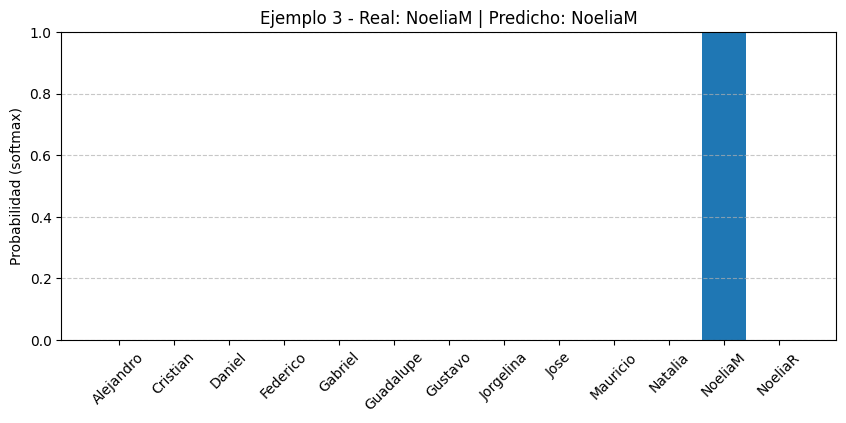

In [119]:
# Predecimos sobre los primeros 3 ejemplos
df_sample = df_train.head(3)
y_pred = mp.predecir(df_sample, campos=[f"x{i+1}" for i in range(10)], clase="y")

clases_pred = y_pred[0]         # clases predichas (strings)
softmax_outputs = y_pred[1]     # vectores de probabilidad (softmax)
etiquetas_reales = df_sample.select("y").to_series().to_list()
clases = mp.red['arq']['output_values']

# Graficamos cada vector de softmax
for i, probs in enumerate(softmax_outputs):
    plt.figure(figsize=(10, 4))
    plt.bar(clases, probs)
    plt.ylim(0, 1)
    plt.title(f"Ejemplo {i+1} - Real: {etiquetas_reales[i]} | Predicho: {clases_pred[i]}")
    plt.ylabel("Probabilidad (softmax)")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

### **Visualización de resultados del entrenamiento**

Se muestran las métricas finales del entrenamiento de la red neuronal: cantidad de epoch ejecutadas, error cuadrático medio (MSE) y tasa de error sobre el conjunto de entrenamiento (train_error_rate). Estos valores permiten evaluar el desempeño alcanzado por el modelo.

In [12]:
# las metricas basica de la red
print("epoch :", epoch)
print("MSE :", MSE)
print("train_error_rate :", train_error_rate)

epoch : 380
MSE : 5.983099770596822e-06
train_error_rate : 0.0


#### **Visualización de los pesos de la primera capa oculta**

Se imprimen los pesos (W) y los sesgos (w0) correspondientes a la primera capa oculta de la red neuronal. Estos valores representan cómo se conectan las entradas del modelo con las neuronas de esta capa, y son clave para entender cómo comienza el proceso de transformación de los datos dentro de la red.

In [ ]:
# la primera hidden layer
print("W :", mp.red["layer"][0]["W"])
print()
print("w0 :", mp.red["layer"][0]["w0"])

W : [[ 0.22221163  0.7238544   0.61660065 ...  0.38332525  0.31970411
   0.4333264 ]
 [ 0.95973216 -1.12269697 -0.76179905 ...  0.45275612 -0.13713691
   0.01583639]
 [-0.16343343 -0.73161414 -0.94938034 ...  0.38807547  0.00956814
   0.74316813]
 ...
 [-0.66185489  0.13477065 -0.60110658 ... -0.58798883  0.39511209
   0.10750586]
 [ 0.84300935  0.177279   -0.86501432 ... -0.31114714  0.37817811
   0.02239018]
 [-0.19338503 -1.11356505 -0.61969918 ... -0.14224618  0.14364757
   0.9351219 ]]

w0 : [[ 0.52696602]
 [-0.36670852]
 [ 0.06178652]
 [ 0.50587956]
 [-0.33421401]
 [ 0.11129732]
 [-1.7098953 ]
 [ 0.07971607]
 [-0.1255316 ]
 [ 0.49166981]
 [ 0.44483862]
 [ 0.37587887]
 [-0.51919988]
 [ 0.24448757]
 [ 0.08614736]
 [-0.23353277]
 [ 0.02410235]
 [-1.5757168 ]
 [ 0.26831457]
 [-0.02572718]
 [ 0.78170304]
 [-0.54286605]
 [ 0.43493794]
 [ 0.64321478]
 [-0.24929054]
 [-0.01379161]
 [ 0.56299315]
 [ 0.17228947]
 [-0.41456091]
 [ 0.877017  ]
 [ 0.36273743]
 [-0.7269561 ]
 [ 0.13004597]
 [-

## **Predicción sobre los datos de prueba**

En esta sección se evalúa el modelo utilizando el dataset de testing, que contiene datos distintos a los utilizados durante el training. Esto permite medir la capacidad de generalización del modelo y comprobar si puede reconocer correctamente nuevas imágenes.

### **Predicción en datos de prueba (evaluación en caliente)**

Se carga el conjunto de prueba y se aplica la red neuronal entrenada para realizar predicciones. El modelo genera tanto la clase predicha (y_hat) como la probabilidad asociada (y_raw) para cada muestra, y se calcula la tasa de error (test_error_rate). Esta evaluación permite medir el desempeño del modelo frente a datos no vistos durante el training.

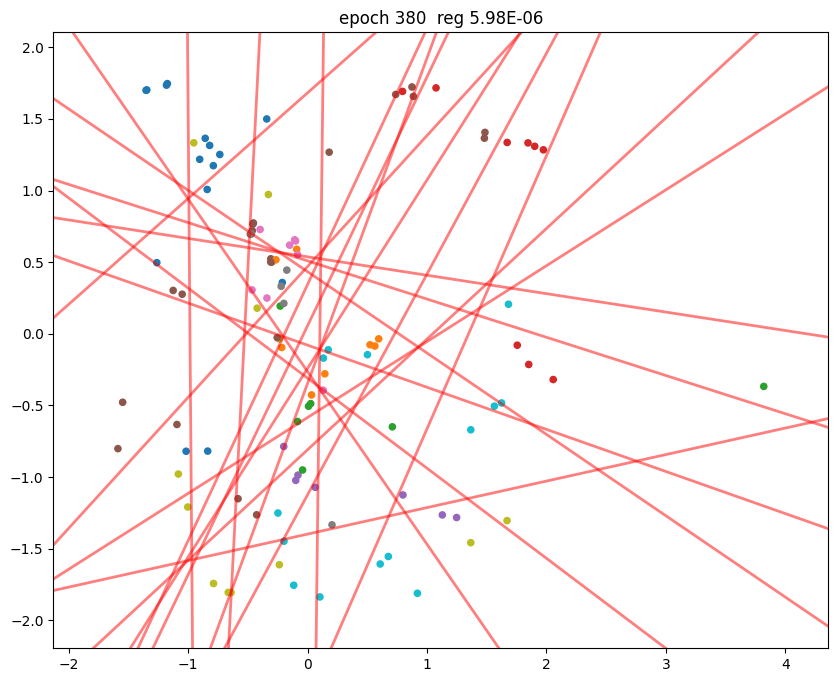

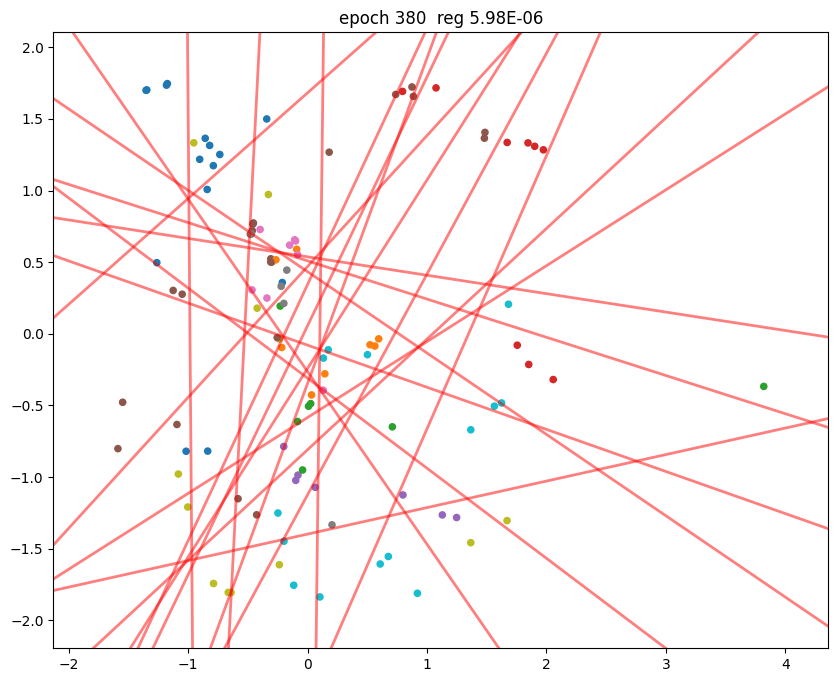

In [13]:
# Lectura del dataset test
with open('/content/drive/MyDrive/DMA_Eigenfaces/modelos/isomap_test.pkl', 'rb') as f:
    df_test = pickle.load(f)

# aplico la red entrenada al dataset de testing

(y_hat,y_raw, test_error_rate) = mp.predecir(df_new=df_test, campos=[f"x{i+1}" for i in range(10)], clase="y")

### **Visualizacion del error en testing**

Se comparan las tasas de error obtenidas en el dataset de training y en el testing. Esta comparación permite evaluar la capacidad del modelo para generalizar y detectar posibles signos de sobreajuste.

In [14]:
print("error_rate (train, test): ",  train_error_rate, test_error_rate)

error_rate (train, test):  0.0 0.11320754716981132


### **Visualizacion de la prediccion en testing**

NameError: name 'st_salida_test' is not defined

Se construye un DataFrame que muestra, para cada muestra del dataset de testing, la clase verdadera (clase), la clase predicha por el modelo (pred) y el valor de activación de salida (y_raw). Esta tabla permite analizar en detalle el comportamiento del modelo frente a datos no vistos.

In [104]:
confianza_max = [max(vec) for vec in y_raw]

tb_salida_test = pl.DataFrame({
    "clase": df_test["y"],
    "pred": y_hat,
    "confianza_max": confianza_max
})

tb_salida_test

shape: (106, 3)
┌───────────┬───────────┬───────────────┐
│ clase     ┆ pred      ┆ confianza_max │
│ ---       ┆ ---       ┆ ---           │
│ str       ┆ str       ┆ f64           │
╞═══════════╪═══════════╪═══════════════╡
│ Natalia   ┆ Natalia   ┆ 0.995377      │
│ Alejandro ┆ Alejandro ┆ 0.988209      │
│ Jose      ┆ Jose      ┆ 0.999518      │
│ Jorgelina ┆ Jorgelina ┆ 0.999936      │
│ Gustavo   ┆ Gustavo   ┆ 0.999153      │
│ …         ┆ …         ┆ …             │
│ Gustavo   ┆ Gustavo   ┆ 0.999762      │
│ Federico  ┆ Daniel    ┆ 0.9417        │
│ NoeliaM   ┆ NoeliaM   ┆ 0.57157       │
│ NoeliaM   ┆ NoeliaM   ┆ 0.997189      │
│ Jorgelina ┆ Jorgelina ┆ 0.999918      │
└───────────┴───────────┴───────────────┘

## 4 Prediccion en datos NUEVOS


*   La red fue entrenada en el pasado, y se grabó al drive
*   Ya no esta disponible la sesion donde se entreno
*   No quiero volver a entrenar de cero

In [ ]:
# cargo datos NUEVOS
df_new = pl.read_csv('https://storage.googleapis.com/open-courses/austral2025-af91/nuevos02.txt', separator='\t')
df_new.shape

(180, 3)

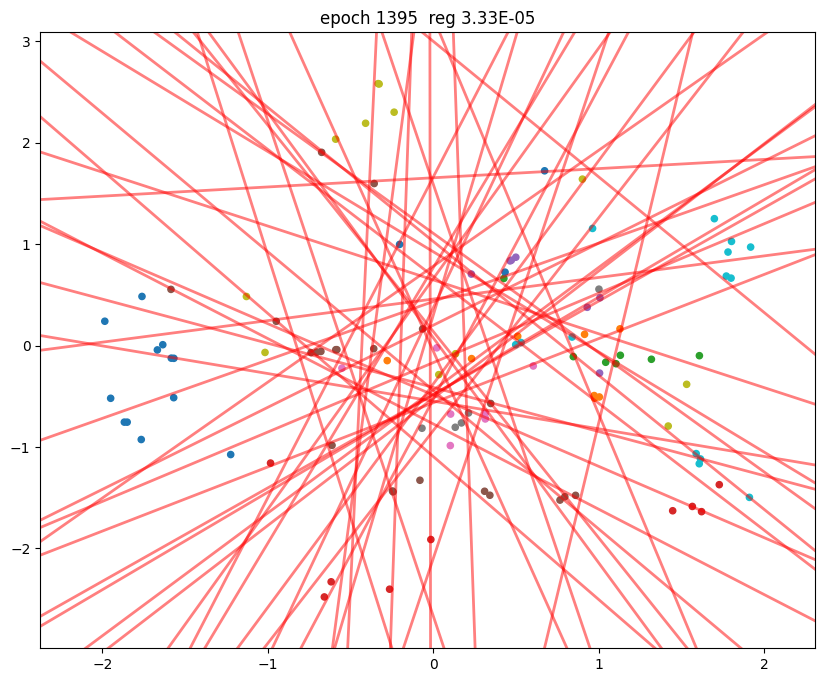

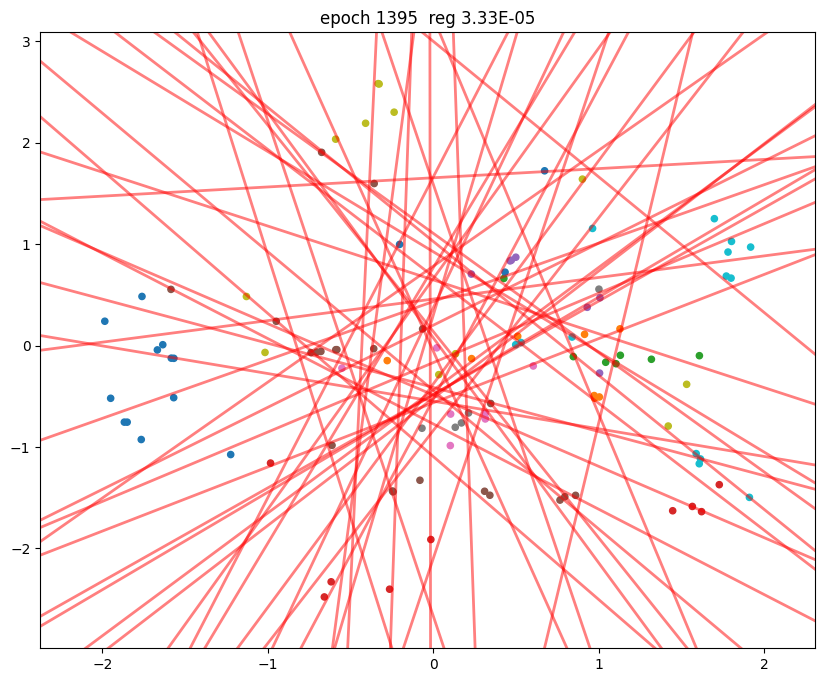

In [ ]:
# cargo modelo grabado y lo aplico a los datos nuevos

carpeta = "/content/drive/MyDrive/DMA_Eigenfaces/red_prueba_funciona"  # la carpeta del modelo entrenado

mp_frio = multiperceptron()
(epoch, MSE, train_error_rate) = mp_frio.cargar_modelo(carpeta)

(y_hat, y_raw, new_error_rate) = mp_frio.predecir(df_new=df_test, campos=[f"x{i+1}" for i in range(30)], clase='y')

#### Visualizacion del error modeloa aplicado a datos nuevos

In [ ]:
print("error_rate (train, new): ",  train_error_rate, new_error_rate)

error_rate (train, new):  0.0 0.14150943396226415


#### Visualizacion de la prediccion en datos nuevos

In [ ]:
tb_salida_new = pl.DataFrame( {"clase":df_new["y"], "pred":y_hat, "y_raw":y_raw })
tb_salida_new